In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stat

In [54]:
DAP_SPECIES = "PSIMIAE"
#DAP_SPECIES = "ECOLI"
FILTER_OUT_REDUNDANT = True
VALID_HITS_ONLY = True
MIN_MOTIF_SCORE = 50
MIN_LOG10_PEAK_SCORE = 0

In [3]:
if FILTER_OUT_REDUNDANT:
    filter_criteria_msg = "redundants excluded"
else:
    filter_criteria_msg = "redundants included"

if VALID_HITS_ONLY:
    filter_criteria_msg += ", valid hits"
else:
    filter_criteria_msg += ", all hits"



In [4]:
DATA_PATH    = F"/global/homes/v/vsevim/scratch/ML/grammar/data/{DAP_SPECIES}_RESULTS"
fimo_df_path = f"{DATA_PATH}/ALL_FIMO_HITS_ANNOTATED_W_PEAKS.pkl"

In [39]:
min_num_sites = 10
max_dist = 205

df_all_hits = pd.read_pickle(fimo_df_path)
df_all_hits['log10_peak_score'] = np.log10(df_all_hits['peak_score'].astype(float))
valid_filter = (df_all_hits.target_is_ortho) & \
              (df_all_hits.dist_to_pref_tgt <= max_dist)
redundant_filter = (df_all_hits.redundant == False) 

if FILTER_OUT_REDUNDANT:
    ortho_filter = valid_filter & redundant_filter
else:
    ortho_filter = valid_filter
                
df_filtered_hits = df_all_hits[ortho_filter] 

In [6]:
df_filtered_hits.head(2)

chr   start     end  score strand  x  \
2   CP001978.1    6702    6722   46.3      -  .   
24  CP001978.1  574970  574995   96.6      +  .   

                                                 anno intergenic_chr  \
2   Name=Ps204_CP001978.1-;Alias=MEME-1;ID=Ps204-M...     CP001978.1   
24  Name=Ps453_CP001978.1+;Alias=MEME-1;ID=Ps453-M...     CP001978.1   

    intergenic_start  intergenic_end  ... peak_score peak_start  peak_end  \
2               6310            6909  ...       1774       6693      6753   
24            574336          575041  ...      89754     574964    575024   

    indexcol index_of_merged_site redundant midpoint length  \
2          2                 6605     False     6712     20   
24        24                11972     False   574983     25   

    prefferred_target_loc  dist_to_pref_tgt  
2              downstream               197  
24             downstream                58  

[2 rows x 40 columns]

# Create peak stats df

In [7]:
df_groups  = df_filtered_hits.groupby(['tf_id','intergenic_label','peak_id'])
hit_counts = [len(df_group) for group_name, df_group in df_groups]
peak_stuff = [
                [
                    str(group_name[0]),
                    group_name[2],
                    df_group['peak_score'].astype(float).values[0],
                    len(df_group),
                    df_group['length'].values[0]
                ]
                    for group_name, df_group in df_groups
            ]

col_names = ['tf_id', 'peak_id', 'peak_score', 'hit_count', 'motif_length']
df_peak_stats = pd.DataFrame(peak_stuff, columns=col_names)
df_peak_stats['log10_peak_score'] = np.log10(df_peak_stats['peak_score'])

In [8]:
num_peaks = len(df_peak_stats)
print(num_peaks, f" peaks found in {DAP_SPECIES} set")

1716  peaks found in PSIMIAE set


In [9]:
df_peak_stats.head()

tf_id                          peak_id  peak_score  hit_count  motif_length  \
0     4  4_D-TGAGGATG+GATTGCAC_peak_1101    783715.0          2            19   
1     4   4_D-TGAGGATG+TTGTGCAG_peak_79a     32187.0          1            19   
2     4    4_D-TGAGGATG+TTGTGCAG_peak_91     29557.0          1            19   
3     4   4_D-TGAGGATG+TTGTGCAG_peak_830    108727.0          2            19   
4     4  4_D-TGAGGATG+TTGTGCAG_peak_1118    404111.0          2            19   

   log10_peak_score  
0          5.894158  
1          4.507681  
2          4.470660  
3          5.036337  
4          5.606501

# Test: Calculate intervals between motifs

In [10]:
# all_intervals = []
# all_monotonic_intervals = []

# NON_MONOTONIC_DIST_FILLER = [np.NAN]

# i = 0
# df_groups  = df_filtered_hits.groupby(['peak_id', 'strand'])
# for index, df_group in df_groups:
#     intervals = np.NAN
#     monotonic = False
#     if (len(df_group) > 1):
#         # There is more than one hit under the peak
#         intervals = df_group['start'].diff().dropna().tolist()
#         uniq_intervals = set(intervals)
        
#         if len(uniq_intervals) == 1:
#             # Interval(s) betw hits under the peak are monotonic                 
#             monotonic = True
#             all_monotonic_intervals += intervals
#         else:
#             # Interval(s) betw hits under the peak are NOT monotonic                 
#             all_monotonic_intervals += NON_MONOTONIC_DIST_FILLER
#     else:
#         # There is only one site
#         all_monotonic_intervals += NON_MONOTONIC_DIST_FILLER
#         intervals = [np.NAN]
            
#     all_intervals += [intervals]
    
#     tf = set(df_group['tf_id'].values)
#     strands = df_group['strand'].values

#     if (len(df_group)>2) and len(set(strands)) >1  :
#         print(tf, index, intervals, strands)
    
#     i += 1    
#     if i > 100:
#         break

# Define interval func

In [11]:
# This function returns the intervals between consecutive motifs
# on a given strand.

def get_intervals(df, peak_id, strand):    
    all_intervals = []
    filter_exp = (df['peak_id'] == peak_id) & (df['strand'] == strand)
    df_selected = df[filter_exp]

    #print(df_selected)
    intervals = np.NAN
    if (len(df_selected) > 1):
        # There is more than one hit under the peak
        intervals = df_selected['start'].diff().dropna().astype(int).tolist()
        uniq_intervals = set(intervals)
    else:
        # There is only one site
        intervals = []
            
    all_intervals += intervals
    
#    if len(all_intervals) == 1:
#        return all_intervals[0]

    if len(all_intervals) > 0:    
        return all_intervals
    else:
        return []

In [12]:
def get_intervals_on_both_strands(df, peak_id):
    dist_sense     = get_intervals(df, peak_id, "+")
    dist_antisense = get_intervals(df, peak_id, "-")
    #if (len(dist_sense) > 0) or (len(dist_antisense)>0):  
    return [dist_sense, dist_antisense]

# Debug

In [13]:
#get_intervals(df_filtered_hits, "4_D-TGAGGATG+GATTGCAC_peak_1101", "+")
#get_intervals(df_filtered_hits, "4_D-TGAGGATG+TTGTGCAG_peak_79a", "+")

peak_id = "4_D-TGAGGATG+AGCAGTAG_peak_3015"
filter_peak = df_filtered_hits['peak_id'] == "4_D-TGAGGATG+AGCAGTAG_peak_3015"
[dist_sense, dist_antisense] = get_intervals_on_both_strands(df_filtered_hits, peak_id)
#df_filtered_hits[filter_peak][['chr', 'u_accession', 'd_accession', 'length']]

# Get inter-motif intervals into the df

Get sense and antisense intervals seperately, then combine them

In [14]:
intervals_between_hits_sense     = [get_intervals(df_filtered_hits, peak_id, "+") for peak_id in df_peak_stats['peak_id']]
intervals_between_hits_antisense = [get_intervals(df_filtered_hits, peak_id, "-") for peak_id in df_peak_stats['peak_id']]
assert len(intervals_between_hits_antisense) == len(intervals_between_hits_sense)
dummy = [list(set(pair[0]+pair[1])) for pair in zip(intervals_between_hits_antisense, intervals_between_hits_sense)]

In [15]:
# replace empty arrays with nan
intervals_combined = [np.NAN if len(d)==0 
                      else d[0] if len(d)==1
                      else d
                      for d in dummy]

# If there is only a single interval value under the peak, then I consider the interval constant
is_constant = [True if type(d) is int else False for d in intervals_combined]

Put them into the df

In [16]:
df_peak_stats['sense_intervals_uniq']     = intervals_between_hits_sense
df_peak_stats['antisense_intervals_uniq'] = intervals_between_hits_antisense
df_peak_stats['both_intervals_uniq']      = intervals_combined
df_peak_stats['constant_interval']   = is_constant

In [17]:
df_peak_stats[df_peak_stats['hit_count']>2].head(8)

tf_id                           peak_id  peak_score  hit_count  \
32      4   4_D-TGAGGATG+AGCAGTAG_peak_3015    121848.0          4   
36      4   4_D-TGAGGATG+TTGAAGCC_peak_4970     58268.0          4   
173    34  34_D-TTTTGGGG+TTGTGCAG_peak_3257       983.0          3   
177    39  39_D-CAGTTGCA+TTGTGCAG_peak_2503     69593.0          3   
215    48   48_D-GCTGGAAA+TTATGGGC_peak_725      1130.0          3   
216    48  48_D-GCTGGAAA+AGCAGTAG_peak_3475       571.0          3   
277    61  61_D-ATGCGTCA+GTGAGATG_peak_2055     43466.0          3   
399   101  101_D-TGGTGACT+ACTACGCA_peak_483    383728.0          4   

     motif_length  log10_peak_score sense_intervals_uniq  \
32             19          5.085818                 [26]   
36             19          4.765430                 [26]   
173            20          2.992554                 [23]   
177            14          4.842566                   []   
215            14          3.053078                   []   
216            14          2.756636                  [8]   
277            20          4.638150              [9, 22]   
399            31          5.584023              [7, 13]   

    antisense_intervals_uniq both_intervals_uniq  constant_interval  
32                      [26]                  26               True  
36                      [26]                  26               True  
173                       []                  23               True  
177                     [11]                  11               True  
215                      [8]                   8               True  
216                       []                   8               True  
277                       []             [9, 22]              False  
399                       []             [13, 7]              False

# Stats

In [18]:
num_valid_hits = len(df_filtered_hits)
num_all_hits   = len(df_all_hits)
percentage_valid = 100.*num_valid_hits/num_all_hits
print("{}: {} valid hits out of {} found. %{:.1f} of total.".format(DAP_SPECIES, num_valid_hits, num_all_hits,percentage_valid))

PSIMIAE: 2682 valid hits out of 16046 found. %16.7 of total.


In [19]:
select_const = df_peak_stats['constant_interval']
df_peak_stats_constants = df_peak_stats[select_const]
num_peaks_w_constant_dist = len(df_peak_stats_constants)
print(f"{DAP_SPECIES}: there are {num_peaks_w_constant_dist} peaks with constant motif interval")

PSIMIAE: there are 292 peaks with constant motif spacing


Text(0.5, 1.0, 'PSIMIAE motif scores\n(redundants excluded, valid hits)')

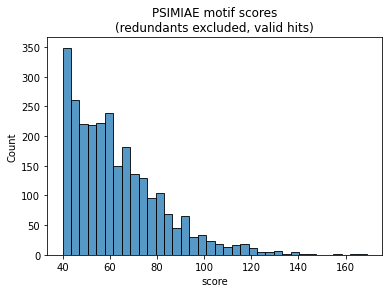

In [32]:
cat_plot = sns.histplot(x='score', data=df_filtered_hits)
cat_plot.set_title(f"{DAP_SPECIES} motif scores\n({filter_criteria_msg})")

Text(0.5, 1.0, 'PSIMIAE motif scores\n(all hits)')

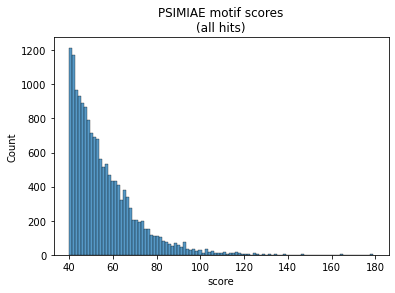

In [33]:
cat_plot = sns.histplot(x='score', data=df_all_hits)
cat_plot.set_title(f"{DAP_SPECIES} motif scores\n(all hits)")

Text(0.5, 1.0, 'PSIMIAE log peak scores\n(all hits)')

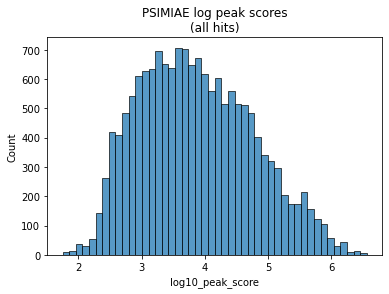

In [41]:
cat_plot = sns.histplot(x='log10_peak_score', data=df_all_hits)
cat_plot.set_title(f"{DAP_SPECIES} log peak scores\n(all hits)")

[Text(0.5, 0, 'motif score')]

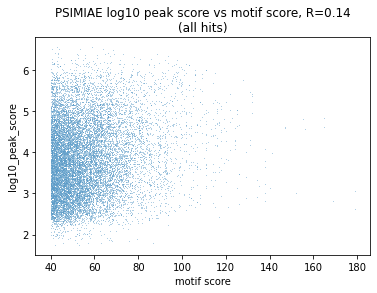

In [67]:
df = df_all_hits
x = df['score']
y = df['log10_peak_score']
R,p = stat.pearsonr(x, y)

plot = sns.scatterplot(y='log10_peak_score', x='score', data=df, s=.5)
plot.set_title(f"{DAP_SPECIES} log10 peak score vs motif score, R={R:.2}\n(all hits)")
plot.set(xlabel="motif score")

Text(0.5, 1.0, 'PSIMIAE motif hits per DAP peak')

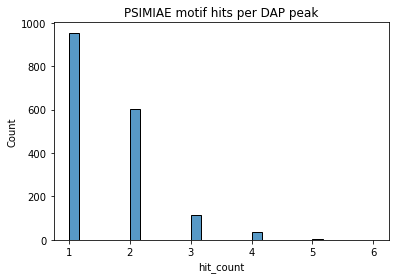

In [22]:
cat_plot = sns.histplot(x='hit_count', data=df_peak_stats)
cat_plot.set_title(f"{DAP_SPECIES} motif hits per DAP peak")

Text(0.5, 1.0, 'PSIMIAE motif lengths\n(redundants excluded, valid hits)')

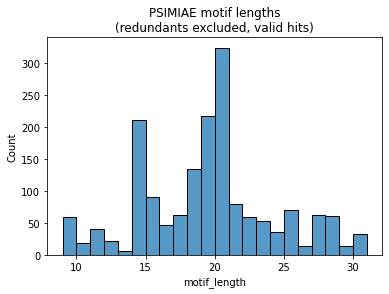

In [69]:
cat_plot = sns.histplot(x='motif_length', data=df_peak_stats)
cat_plot.set_title(f"{DAP_SPECIES} motif lengths\n({filter_criteria_msg})")

Text(0.5, 1.0, 'PSIMIAE intervals\n(constants, redundants excluded, valid hits)')

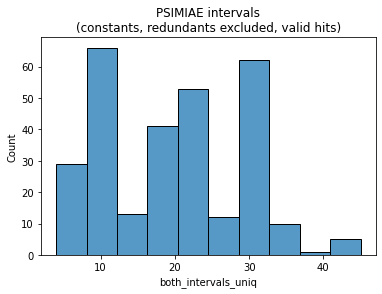

In [68]:
cat_plot = sns.histplot(x='both_intervals_uniq', data=df_peak_stats_constants)
cat_plot.set_title(f"{DAP_SPECIES} intervals\n(constants, {filter_criteria_msg})")

Text(0.5, 0.98, 'PSIMIAE peak score vs motif hits under peak\n(valid hits, redundants excluded, valid hits)')

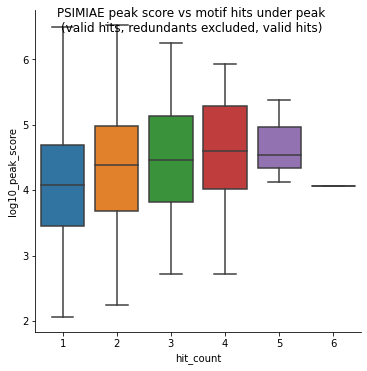

In [25]:
cat_plot = sns.catplot(x='hit_count', y='log10_peak_score', kind='box', data=df_peak_stats)
cat_plot.fig.suptitle(f"{DAP_SPECIES} peak score vs motif hits under peak\n(valid hits, {filter_criteria_msg})")
#cat_plot.set(yscale="log")

Text(0.5, 0.98, 'PSIMIAE peak score vs motif hits under peak\n(valid hits, redundants excluded, valid hits)')

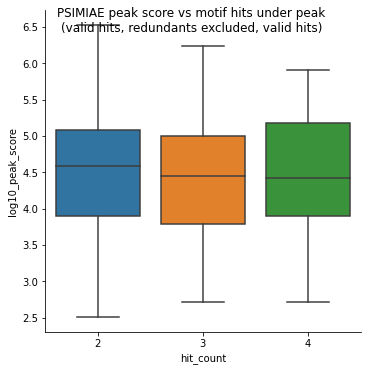

In [26]:
cat_plot = sns.catplot(x='hit_count', y='log10_peak_score', kind='box', data=df_peak_stats_constants)
cat_plot.fig.suptitle(f"{DAP_SPECIES} peak score vs motif hits under peak\n(valid hits, {filter_criteria_msg})")
#cat_plot.set(yscale="log")

Text(0.5, 0.98, 'PSIMIAE peak score vs motif length\n(valid hits, redundants excluded, valid hits)')

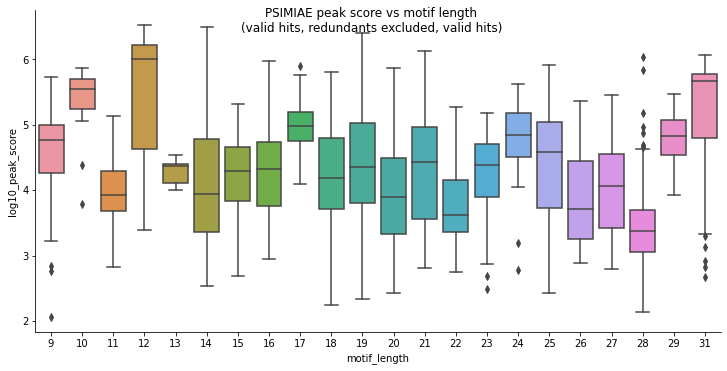

In [27]:
cat_plot = sns.catplot(x='motif_length', y='log10_peak_score', kind='box', data=df_peak_stats, height=5, aspect=2)
cat_plot.fig.suptitle(f"{DAP_SPECIES} peak score vs motif length\n(valid hits, {filter_criteria_msg})")
#cat_plot.set(yscale="log")

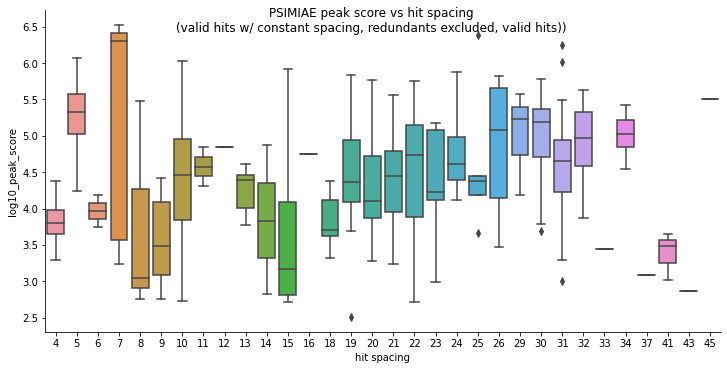

In [28]:
cat_plot = sns.catplot(x='both_intervals_uniq', y='log10_peak_score', kind='box', data=df_peak_stats_constants, height=5, aspect=2)
cat_plot.fig.suptitle(f"{DAP_SPECIES} peak score vs hit interval\n(valid hits w/ constant interval, {filter_criteria_msg}))")
cat_plot.set(xlabel="hit interval")